In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchvision.transforms import v2
import random
from tqdm import tqdm
from torch import GradScaler
random.seed(12)
torch.manual_seed(12)

In [2]:
BATCH_SIZE = 20
BASE_LINK = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash'
METADATA = '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/image_data.csv'

In [ ]:
def load_images(path,metadata):
    images = pd.read_csv(metadata)
    low_res = images['low_res'].values.tolist()
    high_res = images['high_res'].values.tolist()
    low_res = [os.path.join(path,'low res', x) for x in low_res if '_4' in x]
    high_res = [os.path.join(path,'high res', x) for x in high_res]
    return low_res, high_res[:len(low_res)]

In [4]:
low_res,high_res = load_images(BASE_LINK,METADATA)
low_res[:5],high_res[:5]

(['/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/1_4.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/2_4.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/3_4.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/4_4.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/low res/5_4.jpg'],
 ['/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/1.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/2.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/3.jpg',
  '/kaggle/input/image-super-resolution-from-unsplash/Image Super Resolution - Unsplash/high res/4.jpg',
  '/kaggle/input/image-super-resolution-from-unsp

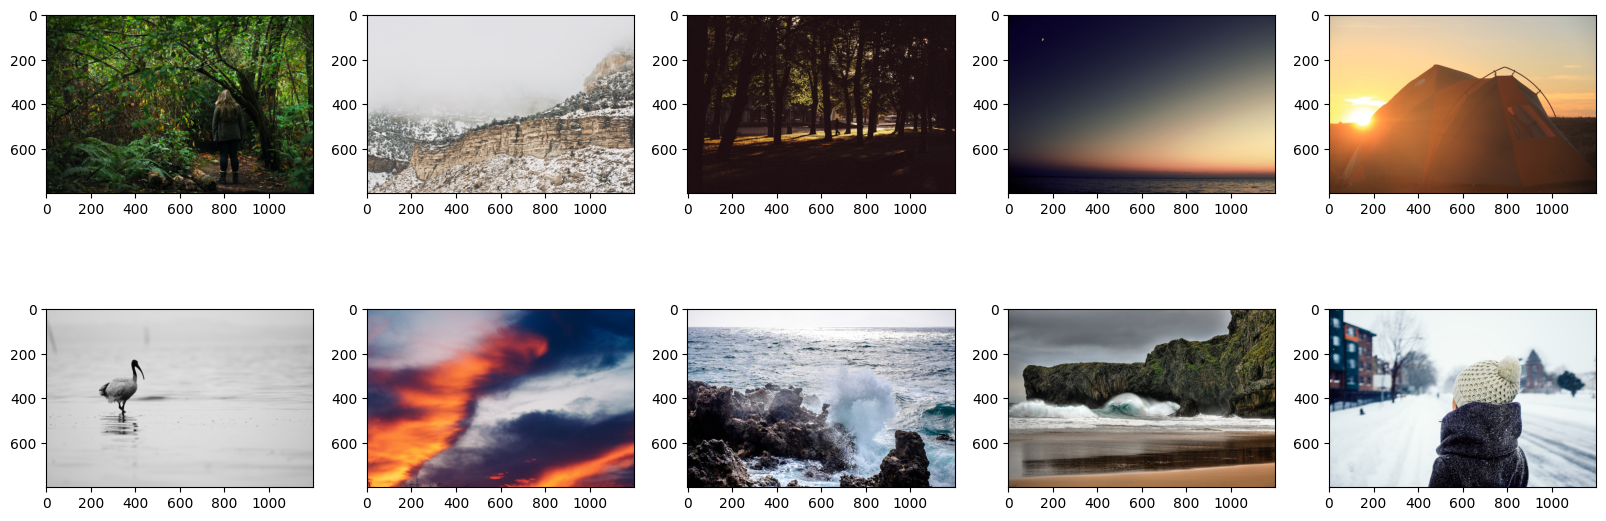

In [5]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    img=cv2.imread(high_res[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i//5,i%5].imshow(img)

In [7]:
from sklearn.model_selection import train_test_split
train_low_res,valid_low_res,train_high_res,valid_high_res = train_test_split(low_res,high_res,test_size=0.1,random_state=42)
len(train_low_res),len(valid_low_res)

(1128, 126)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, high_res_paths, transform):
        self.high_res_paths = high_res_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.high_res_paths)
        
    def __getitem__(self,index):
        high_res_path = self.high_res_paths[index]
        low_res_img, high_res_img = self.image_preprocessing(high_res_path)
        low_res_img, high_res_img = torch.tensor(low_res_img), torch.tensor(high_res_img)
        if self.transform:
            low_res_img,high_res_img = self.transform(low_res_img), self.transform(high_res_img)
        return low_res_img,high_res_img
        
    def image_preprocessing(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        low = cv2.resize(img,(1200//4,800//4),interpolation=cv2.INTER_CUBIC)
        high = cv2.resize(img,(1200,800),interpolation=cv2.INTER_CUBIC)
        low = np.moveaxis(low,-1,0)
        high = np.moveaxis(high,-1,0)
        return low, high

In [9]:
transform = v2.Compose([
    v2.ToDtype(torch.float32,scale=True),
    v2.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

def loading_data(high_res_paths, transform, batch_size, shuffle):
    dataset = ImageDataset(high_res_paths, transform)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle)
    return dataloader

In [10]:
train_loader = loading_data(train_high_res, transform, BATCH_SIZE, True)
val_loader = loading_data(valid_high_res, transform, BATCH_SIZE, False)

In [11]:
for i,(x,y) in enumerate(train_loader):
    if i==1:
        break
    print(x.size(),y.size())

torch.Size([20, 3, 200, 300]) torch.Size([20, 3, 800, 1200])


In [12]:
class SqueezeExcitation(nn.Module):
    def __init__(self,C,r):
        super().__init__()
        model = [
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(C,C//r,1),
            nn.ReLU(),
            nn.Conv2d(C//r,C,1),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*model)
    def forward(self,x):
        return x * self.model(x)

In [ ]:
class RCAB(nn.Module):
    def __init__(self,C,r):
        super().__init__()
        conv=[
            nn.Conv2d(C,C,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(C,C,kernel_size=3,padding=1),
        ]
        self.conv = nn.Sequential(*conv)
        self.ca = SqueezeExcitation(C,r)
    def forward(self,x):
        h = self.conv(x)
        h = self.ca(h)
        return h+x

class RG(nn.Module):
    def __init__(self,C,r,num_RCAB=10):
        super().__init__()
        model = [RCAB(C,r) for i in range(num_RCAB)]
        model.append(nn.Conv2d(C,C,kernel_size=3,padding=1))
        self.model = nn.Sequential(*model)
    def forward(self,x):
        return x + self.model(x)

In [ ]:
class RiR(nn.Module):
    def __init__(self,C,r,num_RG=5):
        super().__init__()
        model = [RG(C,r) for i in range(num_RG)]
        model.append(nn.Conv2d(C,C,kernel_size=3,padding=1))
        self.model = nn.Sequential(*model)
    def forward(self,x):
        return x + self.model(x)

In [ ]:
class RCAN(nn.Module):
    def __init__(self, C=64, r=16):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = [
            nn.Conv2d(3,C,kernel_size=3,padding=1),
            RiR(C=C,r=r),
            nn.PixelShuffle(upscale_factor=4),
            nn.Conv2d(4,3,kernel_size=3,padding=1),
            nn.Tanh()
        ]
        self.model = nn.DataParallel(nn.Sequential(*model)).to(self.device)
        self.loss_fn = nn.L1Loss()
        self.opt = torch.optim.AdamW(self.parameters(),lr=2e-4)
        self.scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=self.opt,
                                                                      patience=5,
                                                                      min_lr=1e-6,
                                                                      factor=0.2)
        self.scaler = GradScaler(self.device)
        self.iters_to_accumulate = 2
    def forward(self,x):
        h = self.model(x)
        return h

    def prepare_input(self,x,y):
        self.low_res = x.to(self.device)
        self.high_res = y.to(self.device)

    def optimize(self,x,y,iter,num_batch):
        self.prepare_input(x,y)
        self.train()
        with torch.autocast(device_type=self.device,dtype=torch.float16):
            pred = self.forward(self.low_res)
            loss = self.loss_fn(pred,self.high_res)
            loss = loss / self.iters_to_accumulate
        self.scaler.scale(loss).backward()
        if (iter % self.iters_to_accumulate == 0) or (iter == num_batch):
            self.scaler.step(self.opt)
            self.scaler.update()
            self.opt.zero_grad()
        return loss.item() * self.iters_to_accumulate

    def evaluate(self,x,y):
        self.prepare_input(x,y)
        self.eval()
        with torch.no_grad():
            with torch.autocast(device_type=self.device,dtype=torch.float16):
                pred = self.forward(self.low_res)
                loss = self.loss_fn(pred,self.high_res)
        return loss.item()

    def predict(self,x):
        self.low_res = x.to(self.device)
        self.eval()
        with torch.no_grad():
            with torch.autocast(device_type=self.device,dtype=torch.float16):
                pred = self.forward(self.low_res)
        return pred

In [ ]:
class Trainer():
    def __init__(self,
                 model) -> None:
        self.model=model
        self.history={'losses':[],
                      'val_losses':[]}

    def __trainstep(self,train_loader: DataLoader, verbose: int):
        train_loss=0
        batches=len(train_loader)
        if verbose == 1:
            train_loader=tqdm(train_loader)
        for iter,(x,y) in enumerate(train_loader):
            loss=self.model.optimize(x,y,iter+1,batches)
            if verbose==1:
                train_loader.set_postfix({'loss':loss})
            train_loss+=loss
        train_loss/=batches
        self.history['losses'].append(train_loss)
    
    def __evalstep(self, val_loader: DataLoader,verbose: int):
        val_loss=0
        batches=len(val_loader)
        if verbose == 1:
            val_loader=tqdm(val_loader)
        for x,y in val_loader:
            loss=self.model.evaluate(x,y)
            if verbose==1:
                val_loader.set_postfix({'val_loss':loss})
            val_loss+=loss
        val_loss/=batches
        self.history['val_losses'].append(val_loss)
        
    def fit(self, train_loader: DataLoader,
            val_loader: DataLoader,
            epochs: int,
            verbose: int,
            patience: int):
        assert verbose in [0,1], 'verbose must be either 0 or 1'
        best_loss = float('inf')
        best_model = None
        try:
            for i in range(epochs):
                if verbose == 1:
                    print(f'\nEpoch: {i+1}')
                self.__trainstep(train_loader, verbose)
                self.__evalstep(val_loader, verbose)
                self.model.scheduler.step(self.history['val_losses'][-1])
                if self.history['val_losses'][-1] - best_loss < 1e-6 :
                    best_loss=self.history['val_losses'][-1]
                    best_model=self.model.state_dict()
                    patience+=1
                else:
                    patience-=1
                    if patience == 0:
                        break
        except KeyboardInterrupt:
            print('Interrupted!')
        finally:
            self.model.load_state_dict(best_model)
            if verbose == 1:
                print(f'best loss:', best_loss)
                
    def predict(self, test_loader):
        preds = []
        for x in test_loader:
            pred = self.model.predict(x[0])
            preds.append(pred.cpu().numpy())
        return np.concatenate(preds,axis=0)

In [ ]:
model = RCAN()
trainer=Trainer(model)

In [20]:
trainer.fit(train_loader,
            val_loader,
            epochs=30,
            verbose=1,
            patience=10)


Epoch: 1


  0%|          | 0/57 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|██████████| 7/7 [00:10<00:00,  1.45s/it, val_loss=0.14] 



Epoch: 2


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0985]



Epoch: 3


100%|██████████| 7/7 [00:09<00:00,  1.31s/it, val_loss=0.0807]



Epoch: 4


100%|██████████| 7/7 [00:08<00:00,  1.29s/it, val_loss=0.0923]



Epoch: 5


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0745]



Epoch: 6


100%|██████████| 7/7 [00:09<00:00,  1.29s/it, val_loss=0.0776]



Epoch: 7


100%|██████████| 7/7 [00:08<00:00,  1.25s/it, val_loss=0.0692]



Epoch: 8


100%|██████████| 7/7 [00:09<00:00,  1.29s/it, val_loss=0.0709]



Epoch: 9


100%|██████████| 7/7 [00:09<00:00,  1.35s/it, val_loss=0.0646]



Epoch: 10


100%|██████████| 7/7 [00:09<00:00,  1.29s/it, val_loss=0.0674]



Epoch: 11


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0608]



Epoch: 12


100%|██████████| 7/7 [00:08<00:00,  1.23s/it, val_loss=0.0611]



Epoch: 13


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0597]



Epoch: 14


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0601]



Epoch: 15


100%|██████████| 7/7 [00:08<00:00,  1.22s/it, val_loss=0.0588]



Epoch: 16


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0585]



Epoch: 17


100%|██████████| 7/7 [00:08<00:00,  1.27s/it, val_loss=0.0566]



Epoch: 18


100%|██████████| 7/7 [00:08<00:00,  1.27s/it, val_loss=0.0593]



Epoch: 19


100%|██████████| 7/7 [00:08<00:00,  1.24s/it, val_loss=0.0585]



Epoch: 20


100%|██████████| 7/7 [00:08<00:00,  1.22s/it, val_loss=0.0578]



Epoch: 21


100%|██████████| 7/7 [00:08<00:00,  1.21s/it, val_loss=0.057] 



Epoch: 22


100%|██████████| 7/7 [00:08<00:00,  1.27s/it, val_loss=0.0568]



Epoch: 23


100%|██████████| 7/7 [00:08<00:00,  1.22s/it, val_loss=0.0568]



Epoch: 24


100%|██████████| 7/7 [00:08<00:00,  1.26s/it, val_loss=0.0553]



Epoch: 25


100%|██████████| 7/7 [00:08<00:00,  1.22s/it, val_loss=0.0617]



Epoch: 26


 53%|█████▎    | 30/57 [01:17<01:09,  2.59s/it, loss=0.0534]

Interrupted!
best loss: 0.05259307154587337


In [21]:
preds = trainer.predict(val_loader)
preds = np.moveaxis(preds,1,-1)
preds = (preds*127.5)+127.5
preds = np.clip(preds, 0, 255).astype(np.uint8)

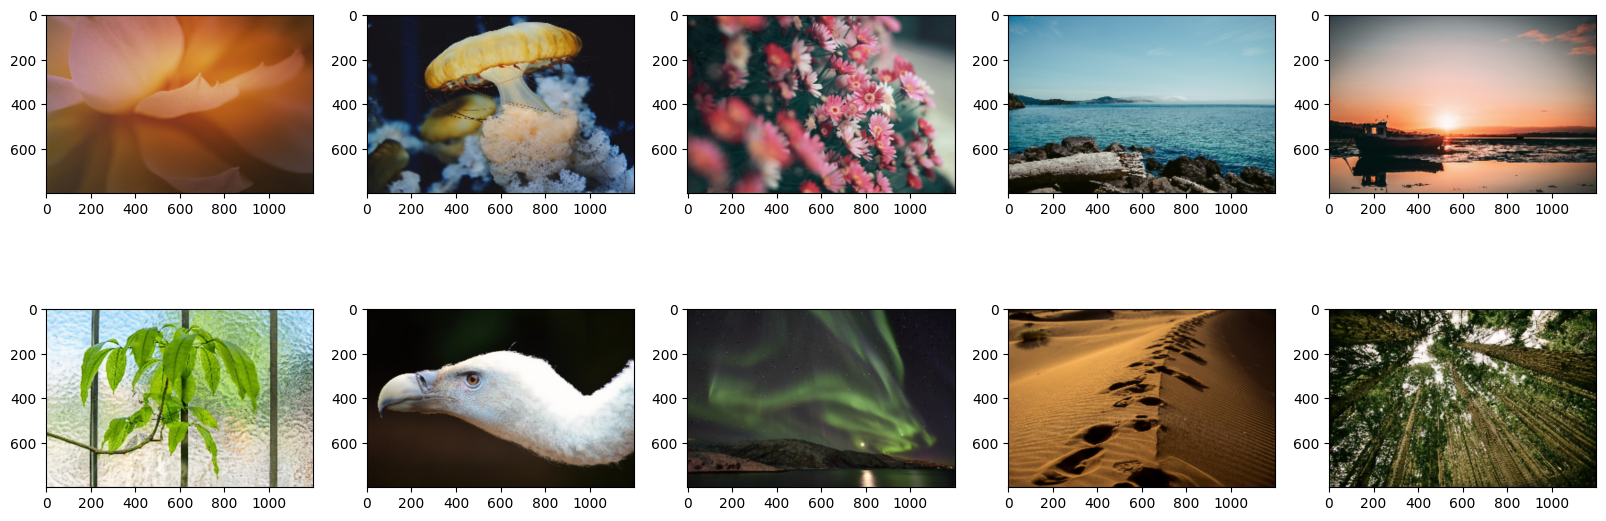

In [22]:
_, ax = plt.subplots(2, 5, figsize=(20,7))
for i in range(10):
    ax[i//5,i%5].imshow(preds[i])

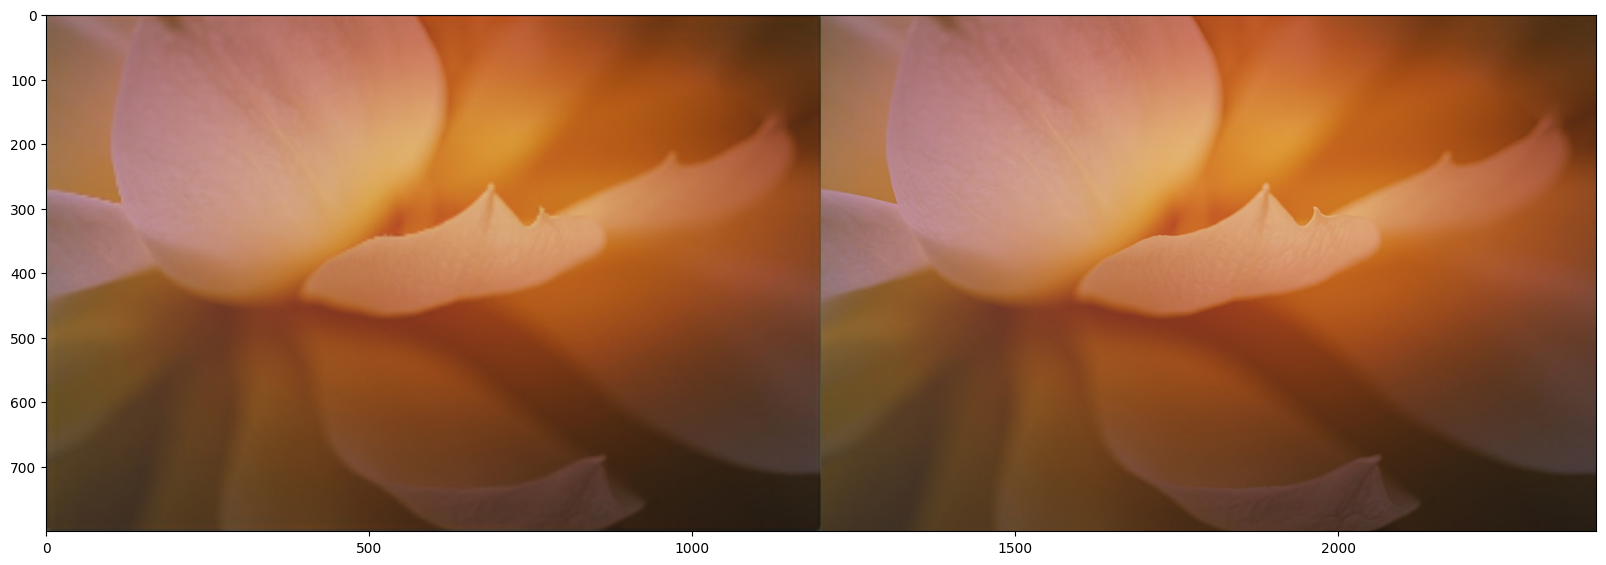

In [ ]:
_, ax = plt.subplots(figsize=(20,7))
pred = preds[0]
high_img = cv2.imread(valid_high_res[0])
high_img = cv2.cvtColor(high_img,cv2.COLOR_BGR2RGB)
stack = cv2.hconcat([pred,high_img])
plt.imshow(stack)

In [24]:
torch.save(trainer.model.state_dict(), '/kaggle/working/rcan1.pth')